In [ ]:
import pandas as pd
import numpy as np
import re

data = pd.read_excel("/content/Abusive Language Detection on Indonesian Online News Comments Dataset .xlsx")
data

,Kalimat,label
0,san ente aje yg unboxing Indosat. masa ente ka...,1
1,"‚Å£‚Å£GOBLOK,ngapain beli indosat ? g ada untu...",3
2,Ngotot mau beli saham indosat kok jika jd pres...,1
3,Buyback Isat??anda sehat??sdh diminum obatnya?...,1
4,"Saya percaya kalau sama Sandiaga Uno, tapi kal...",1
...,...,...
3179,"hentikan aja, ngapai2n audisi2an, pantesa boca...",1
3180,Ini gerombolan orang2 yang mau meruntuhkan bib...,1
3181,KPAI isinya org bodoh ya.gmana pd djarum ga me...,3
3182,Kpai idak ada gunanya. #bubarkan KPAI,1


# cleaning dataset

In [ ]:
# Ubah kolom 'Kalimat' menjadi string
data['Kalimat'] = data['Kalimat'].astype(str)


In [ ]:
def clean_text(Kalimat):
    # Menghapus RT tag
    t1 = re.sub('RT\s', '', Kalimat)
    # Menghapus @_username
    t2 = re.sub(r'\@([\w]+)',' ', t1)
    # Mengganti emoji decode dengan spasi
    t3 = re.sub(r'\\u[a-zA-Z0-9]{4}', ' ', t2)
    # Mengganti enter /n/ dengan spasi
    t4 = re.sub('\n\s', ' ', t3)
    t5 = re.sub('\n', ' ', t4)
    # Non-ascii
    t6 = re.sub(r'[^\x00-\x7F]+',' ', t5)
    # Koreksi duplikasi tiga karakter beruntun atau lebih (contoh. yukkk)
    t7 = re.sub(r'([a-zA-Z])\1\1','\\1', t6)
    # Replace URL
    t8 = re.sub(r'http[s]?\:\/\/.[a-zA-Z0-9\.\/\_?=%&#\-\+!]+',' ', t7)
    t9 = re.sub(r'pic.twitter.com?.[a-zA-Z0-9\.\/\_?=%&#\-\+!]+',' ', t8)
    # Konversi ke karakter huruf kecil
    t10 = t9.lower()
    # Hapus tagar
    t11 = re.sub(r'\#[a-zA-Z0-9_]+','', t10)
    # Hapus angka
    t12 = re.sub(r'[0-9]+',' ', t11)
    # Hapus simbol
    t13 = re.sub(r'[!$%^&*@#()_+|~=`{}\[\]%\-:";\'<>?,.\/]', ' ', t12)
    # Spasi ganda (atau lebih) menjadi satu spasi
    t14 = re.sub(' +', ' ', t13)
    # Spasi di awal dan akhir kalimat
    t15 = re.sub(r'^[ ]|[ ]$','', t14)
    return t15

In [ ]:
for i, r in data.iterrows():
    y = clean_text(r['Kalimat'])
    data.loc[i, 'Kalimat'] = y
data

,Kalimat,label
0,san ente aje yg unboxing indosat masa ente kal...,1
1,goblok ngapain beli indosat g ada untungnya ja...,3
2,ngotot mau beli saham indosat kok jika jd pres...,1
3,buyback isat anda sehat sdh diminum obatnya si...,1
4,saya percaya kalau sama sandiaga uno tapi kala...,1
...,...,...
3179,hentikan aja ngapai n audisi an pantesa boca k...,1
3180,ini gerombolan orang yang mau meruntuhkan bibi...,1
3181,kpai isinya org bodoh ya gmana pd djarum ga me...,3
3182,kpai idak ada gunanya kpai,1


# Menghilangkan data duplikat dan Nan

In [ ]:
# Menghapus baris data duplikat
data.drop_duplicates(inplace=True)

# Menghapus baris data kosong (baris dengan nilai NaN)
data.dropna(inplace=True)

# Reset index setelah penghapusan baris
data.reset_index(drop=True, inplace=True)

# Labeling using InSet Lexicon

In [ ]:
def sa_lexicon_indonesia(text, lexicon_positive, lexicon_negative):
    score = 0

    # Split text
    words = text.split()
    phrases = []
    for i in range(len(words) - 1):
      phrase = words[i] + " " + words[i + 1]
      phrases.append(phrase)

    # Menghitung skor sentimen berdasarkan kata dan frasa
    for word in words:
        if word in positive_lexicon:
            score += positive_lexicon[word]
        elif word in negative_lexicon:
            score += negative_lexicon[word]

    for phrase in phrases:
        if phrase in positive_lexicon:
            score += positive_lexicon[phrase]
        elif phrase in negative_lexicon:
            score += negative_lexicon[phrase]

    sentimen = 'Netral'
    if score > 0:
        sentimen = 'Positif'
    elif score < 0:
        sentimen = 'Negatif'

    return score, sentimen

def load_lexicon(path):
    lexicon = {}
    with open(path, 'r', encoding='utf-8') as file:
        next(file)  # Lewati baris header
        for line in file:
            word_or_phrase, polarity = line.strip().split('\t')
            lexicon[word_or_phrase.lower()] = float(polarity)
    return lexicon

# Input lexicon dari file TSV
positive_lexicon = load_lexicon("positive.tsv")
negative_lexicon = load_lexicon("negative.tsv")

# Contoh teks pertama
text = data['Kalimat'].iloc[0]
# Melakukan analisis sentimen menggunakan lexicon
predicted_score, predicted_label = sa_lexicon_indonesia(text, positive_lexicon, negative_lexicon)
print(f"Teks: {text}")
print(f"Skor sentimen: {predicted_score:.2f} ({predicted_label})")

Teks: san ente aje yg unboxing indosat masa ente kalah ama kemenakan prabowo unboxing mesin atm wkwkwkwkwk
Skor sentimen: -4.00 (Negatif)


In [ ]:
correct_predictions = 0
incorrect_predictions = 0
predicted_sentiments = []

for index, row in data.iterrows():
  text = row['Kalimat']
  actual_sentiment = row['label']

  predicted_score, predicted_sentiment = sa_lexicon_indonesia(text, positive_lexicon, negative_lexicon)

# Membandingkan label yang diprediksi dengan label aktual
  if predicted_sentiment == 'Positif' and actual_sentiment == 1:
        sentiment_label = 'Positif (Not Abusive)'
  elif predicted_sentiment == 'Netral' and actual_sentiment == 2:
        sentiment_label = 'Negatif (Abusive but Not Offensive)'
  elif predicted_sentiment == 'Negatif' and actual_sentiment == 3:
        sentiment_label = 'Negatif (Offensive)'
  else:
        sentiment_label = 'Netral'

  predicted_sentiments.append(sentiment_label)

  # compare
  if predicted_sentiment == actual_sentiment:
    correct_predictions += 1
  else:
    incorrect_predictions += 1

# Memeriksa penangkapan frasa kata
  phrase_detection_accuracy = False
  for word in text.split():
    if word in positive_lexicon or word in negative_lexicon:
      phrase_detection_accuracy = True
      break

sa_data = pd.DataFrame(columns=['Kalimat', 'Skor Polaritas', 'Sentimen', 'Akurasi penangkapan frasa kata'])
sa_data['Kalimat'] = data['Kalimat']
sa_data['Skor Polaritas'] = data['Kalimat'].apply(lambda x: sa_lexicon_indonesia(x, positive_lexicon, negative_lexicon)[0])
sa_data['Sentimen'] = data['Kalimat'].apply(lambda x: sa_lexicon_indonesia(x, positive_lexicon, negative_lexicon)[1])
sa_data['Valid penangkapan frasa kata'] = phrase_detection_accuracy
sa_data

,Kalimat,Skor Polaritas,Sentimen,Akurasi penangkapan frasa kata,Valid penangkapan frasa kata
0,san ente aje yg unboxing indosat masa ente kal...,-4.0,Negatif,NaN,True
1,goblok ngapain beli indosat g ada untungnya ja...,3.0,Positif,NaN,True
2,ngotot mau beli saham indosat kok jika jd pres...,25.0,Positif,NaN,True
3,buyback isat anda sehat sdh diminum obatnya si...,-2.0,Negatif,NaN,True
4,saya percaya kalau sama sandiaga uno tapi kala...,5.0,Positif,NaN,True
...,...,...,...,...,...
3144,hentikan aja ngapai n audisi an pantesa boca k...,11.0,Positif,NaN,True
3145,ini gerombolan orang yang mau meruntuhkan bibi...,-7.0,Negatif,NaN,True
3146,kpai isinya org bodoh ya gmana pd djarum ga me...,-21.0,Negatif,NaN,True
3147,kpai idak ada gunanya kpai,4.0,Positif,NaN,True


Confusion Matrix:
Prediksi Sentimen  Negatif (Abusive but Not Offensive)  Negatif (Offensive)  \
label                                                                         
1                                             0.000000             0.000000   
2                                             0.003176             0.000000   
3                                             0.000000             0.051762   

Prediksi Sentimen    Netral  Positif (Not Abusive)  
label                                               
1                  0.526516               0.348682  
2                  0.031439               0.000000  
3                  0.038425               0.000000  


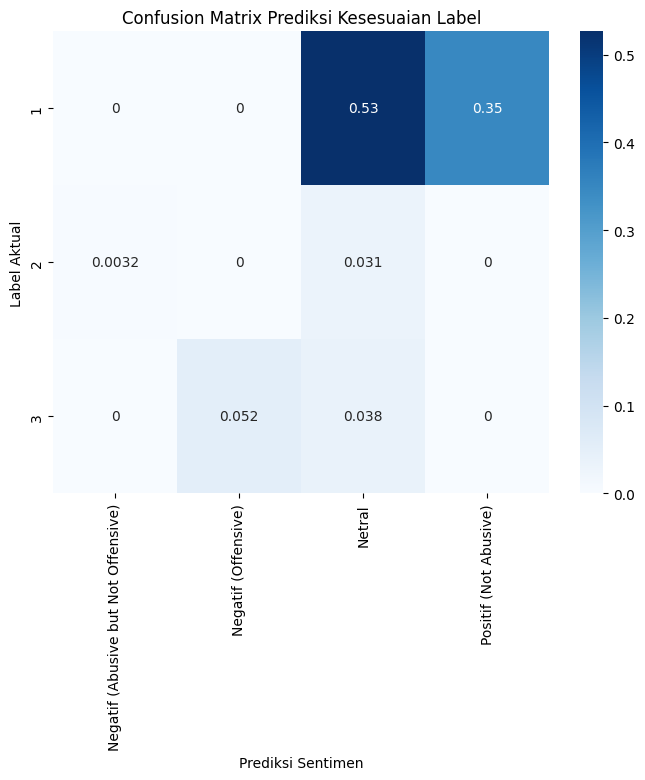

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
data['Prediksi Sentimen'] = predicted_sentiments
# Membangun Confusion Matrix
confusion_matrix = pd.crosstab(data['label'], data['Prediksi Sentimen'], normalize=True)

# Menampilkan Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix)

# Memvisualisasikan Confusion Matrix dengan Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='.2g', cmap='Blues')
plt.ylabel('Label Aktual')
plt.xlabel('Prediksi Sentimen')
plt.title('Confusion Matrix Prediksi Kesesuaian Label')
plt.show()

In [ ]:
inset_counts = sa_data['Sentimen'].value_counts()
inset_counts

Sentimen
Negatif    1647
Positif    1229
Netral      273
Name: count, dtype: int64